In [1]:
import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib.pylab as plt
import config as cf

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from chinese_calendar import is_workday, is_holiday
from jupyterthemes import jtplot

jtplot.style()
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 200

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

In [2]:
train_df = pd.read_csv(cf.round1_train_file_path, sep = ' ')
test_df = pd.read_csv(cf.round1_test_file_path, sep = ' ')

category_df = train_df['item_category_list'].unique()
category_ids = pd.DataFrame({'item_category_list' : category_df, 'item_category_id' : np.arange(len(category_df))})
train_df = train_df.merge(category_ids, on='item_category_list')
test_df = test_df.merge(category_ids, on='item_category_list')

time_offset = 8 * 60 * 60 - 365 * 24 * 60 * 60
train_df.loc[:,'context_datetime'] = pd.to_datetime(train_df.loc[:,'context_timestamp'] + time_offset, unit='s')
test_df.loc[:,'context_datetime'] = pd.to_datetime(test_df.loc[:,'context_timestamp'] + time_offset, unit='s')
train_df.loc[:,'context_day'] = train_df.loc[:,'context_datetime'].map(lambda x:x.day)
test_df.loc[:,'context_day'] = test_df.loc[:,'context_datetime'].map(lambda x:x.day)

stat_df = train_df

In [3]:
# 每项数据结果数量
print train_df.nunique()

# 单项数据结果数量
print train_df['is_trade'].describe()

instance_id                  478087
item_id                       10075
item_category_list               14
item_property_list            10908
item_brand_id                  2055
item_city_id                    128
item_price_level                 14
item_sales_level                 18
item_collected_level             18
item_pv_level                    22
user_id                      197694
user_gender_id                    4
user_age_level                    9
user_occupation_id                5
user_star_level                  12
context_id                   478111
context_timestamp            281824
context_page_id                  20
predict_category_property     78796
shop_id                        3959
shop_review_num_level            25
shop_review_positive_rate     11825
shop_star_level                  22
shop_score_service            16361
shop_score_delivery           16423
shop_score_description        16463
is_trade                          2
item_category_id            

> 有 27% 的测试集用户在训练集中出现过，可以建立“历史用户”特征，提高这部分用户预测率

train user count : 197694, test user count : 13573, both user count : 3626


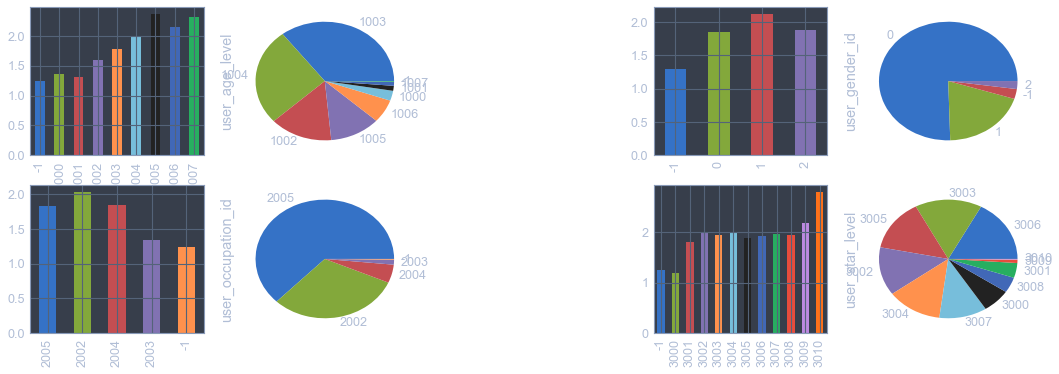

In [4]:
# user info
f = plt.figure(figsize=(18,6))

a = set(train_df['user_id'].tolist())
b = set(test_df['user_id'].tolist())
print 'train user count : %d, test user count : %d, both user count : %d' %(len(a), len(b), len(a & b))

# plot user age trade rates
a = train_df['user_age_level'].value_counts()
y = train_df.loc[train_df['is_trade'] == 1]['user_age_level'].value_counts()
(y / a * 100).plot.bar(ax=f.add_subplot(251))
a.plot.pie(ax=f.add_subplot(252))

# plot user gender trade rates
a = train_df['user_gender_id'].value_counts()
y = train_df.loc[train_df['is_trade'] == 1]['user_gender_id'].value_counts()
(y / a * 100).plot.bar(ax=f.add_subplot(254))
a.plot.pie(ax=f.add_subplot(255))

# plot user start trade rates
a = train_df['user_occupation_id'].value_counts()
y = train_df.loc[train_df['is_trade'] == 1]['user_occupation_id'].value_counts()
(y / a * 100).plot.bar(ax=f.add_subplot(256))
a.plot.pie(ax=f.add_subplot(257))

# plot user occupation trade rates
a = train_df['user_star_level'].value_counts()
y = train_df.loc[train_df['is_trade'] == 1]['user_star_level'].value_counts()
(y / a * 100).plot.bar(ax=f.add_subplot(259))
a.plot.pie(ax=f.add_subplot(2,5,10))

> 有 96% 的测试集商品在训练集中出现过，可以建立“历史商品”特征
> 属性标签，训练集样本中共有10000种属性组合，有6000种类属性

train item count : 10075, test item count : 3695, both item count : 3534
property combination count: 10908, property item count : 61407
                       count  is_trade       rate
 7534238860363577544  154991    2035.0   1.312979
 7322157373578955368   58326    1249.0   2.141412
 3948283326616421003   54472     888.0   1.630195
 5918626470536001929   34952    1092.0   3.124285
 196257267849351217    30276     665.0   2.196459
 3122721854741763495   24762     549.0   2.217107
 1019055478500227370   19701     496.0   2.517639
 4644954126004286009   18749     299.0   1.594752
 4918413420989329604   10683     181.0   1.694281
 6738283504825746594    6877     180.0   2.617420
 2171543029187596030    5916      86.0   1.453685
 8240548652619864253    4257     105.0   2.466526
 3819392654129628501    3921     156.0   3.978577
 4899814843172066235    3734      64.0   1.713980
 6652984710464900997    3348      87.0   2.598566
 9088192369782437159    2938      41.0   1.395507
 2577951605337

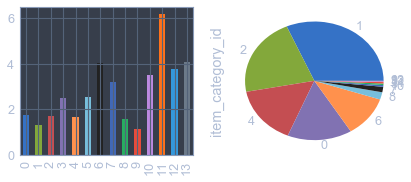

In [5]:
# item info
f = plt.figure(figsize=(18,6))

a = set(train_df['item_id'].tolist())
b = set(test_df['item_id'].tolist())
print 'train item count : %d, test item count : %d, both item count : %d' %(len(a), len(b), len(a & b))

# # encode plot item category list
# if 'item_category_id' not in train_df:
#     category_df = train_df['item_category_list'].unique()
#     category_ids = pd.DataFrame({'item_category_list' : category_df, 'item_category_id' : np.arange(len(category_df))})
#     train_df = train_df.merge(category_ids, on='item_category_list')
#     test_df = test_df.merge(category_ids, on='item_category_list')

# plot item category trade rates
a = train_df['item_category_id'].value_counts()
y = train_df.loc[train_df['is_trade'] == 1]['item_category_id'].value_counts()
(y / a * 100).plot.bar(ax=f.add_subplot(251))
a.plot.pie(ax=f.add_subplot(252))

# todo deal with properties
prop_set = set()
for property_list in train_df['item_property_list'].unique():
    for prop in  property_list.split(';'):
        prop_set.add(prop)
print 'property combination count: %d, property item count : %d' %(len(train_df['item_property_list'].unique()), len(prop_set))
# TODO: calculate high trade rate property

# plot item city id
a = train_df['item_city_id'].value_counts()
y = train_df.loc[train_df['is_trade'] == 1]['item_city_id'].value_counts()
city_map = a.to_frame(name='count').join(y.to_frame(name='is_trade'))
city_map.loc[:, 'rate'] = (city_map['is_trade'] / city_map['count'] * 100)

print city_map

# plot price level
a = train_df['item_price_level'].value_counts()
y = train_df.loc[train_df['is_trade'] == 1]['item_price_level'].value_counts()
price_map = a.to_frame(name='count').join(y.to_frame(name='is_trade'))
price_map.loc[:, 'rate'] = (price_map['is_trade'] / price_map['count'] * 100)
price_map.sort_index().transpose()

train_raw_df = train_df.copy(deep=True)
test_raw_df = test_df.copy(deep=True)

> 属性标签，训练集样本中共有10000种属性组合，有6000种类属性

train shop count : 3959, test shop count : 2015, both user count : 1971


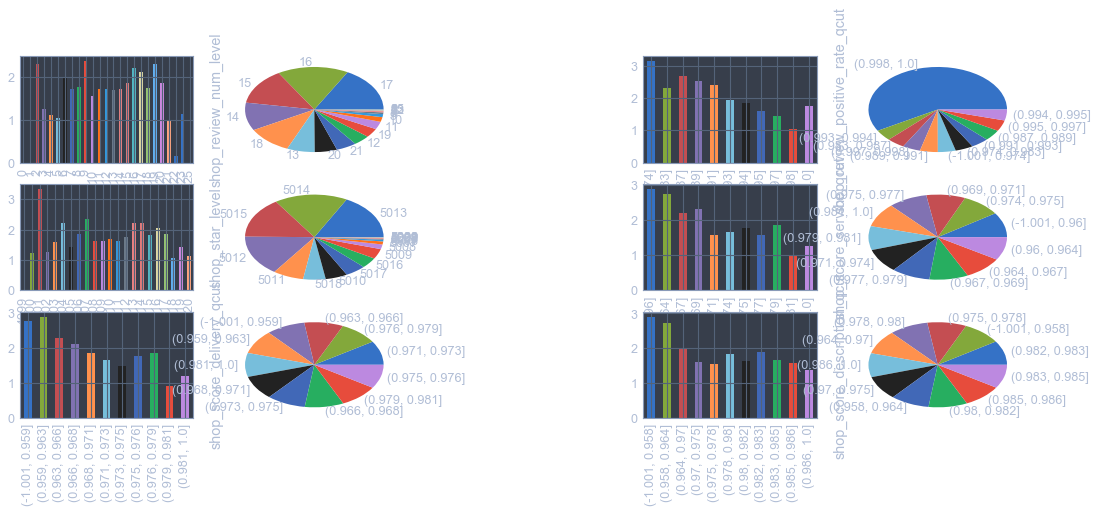

In [6]:
# store info
f = plt.figure(figsize=(18,9))

a = set(train_df['shop_id'].tolist())
b = set(test_df['shop_id'].tolist())
print 'train shop count : %d, test shop count : %d, both user count : %d' %(len(a), len(b), len(a & b))

# plot shop review num level trade rates
a = train_df['shop_review_num_level'].value_counts()
y = train_df.loc[train_df['is_trade'] == 1]['shop_review_num_level'].value_counts()
(y / a * 100).plot.bar(ax=f.add_subplot(451))
a.plot.pie(ax=f.add_subplot(452))

# plot shop review positive rete trade rates
train_df.loc[:,'shop_review_positive_rate_qcut'] = pd.qcut(train_df['shop_review_positive_rate'], 24, duplicates='drop')
# train_df.loc[:,'shop_review_positive_rate_qcut'] = pd.qcut(train_df['shop_review_positive_rate'], 24, duplicates='drop', labels=range(11))
a = train_df['shop_review_positive_rate_qcut'].value_counts()
y = train_df.loc[train_df['is_trade'] == 1]['shop_review_positive_rate_qcut'].value_counts()
(y / a * 100).plot.bar(ax=f.add_subplot(454))
a.plot.pie(ax=f.add_subplot(455))

# plot shop star level trade rates
a = train_df['shop_star_level'].value_counts()
y = train_df.loc[train_df['is_trade'] == 1]['shop_star_level'].value_counts()
(y / a * 100).plot.bar(ax=f.add_subplot(4, 5, 6))
a.plot.pie(ax=f.add_subplot(4, 5, 7))

# plot shop review positive rete trade rates
train_df.loc[:,'shop_score_service_qcut'] = pd.qcut(train_df['shop_score_service'], 11, duplicates='drop')
# train_df.loc[:,'shop_review_positive_rate_qcut'] = pd.qcut(train_df['shop_review_positive_rate'], 24, duplicates='drop', labels=range(11))
a = train_df['shop_score_service_qcut'].value_counts()
y = train_df.loc[train_df['is_trade'] == 1]['shop_score_service_qcut'].value_counts()
(y / a * 100).plot.bar(ax=f.add_subplot(4, 5, 9))
a.plot.pie(ax=f.add_subplot(4, 5, 10))

# plot shop review positive rete trade rates
train_df.loc[:,'shop_score_delivery_qcut'] = pd.qcut(train_df['shop_score_delivery'], 11, duplicates='drop')
# train_df.loc[:,'shop_review_positive_rate_qcut'] = pd.qcut(train_df['shop_review_positive_rate'], 24, duplicates='drop', labels=range(11))
a = train_df['shop_score_delivery_qcut'].value_counts()
y = train_df.loc[train_df['is_trade'] == 1]['shop_score_delivery_qcut'].value_counts()
(y / a * 100).plot.bar(ax=f.add_subplot(4, 5, 11))
a.plot.pie(ax=f.add_subplot(4, 5, 12))

# plot shop review positive rete trade rates
train_df.loc[:,'shop_score_description_qcut'] = pd.qcut(train_df['shop_score_description'], 11, duplicates='drop')
# train_df.loc[:,'shop_review_positive_rate_qcut'] = pd.qcut(train_df['shop_review_positive_rate'], 24, duplicates='drop', labels=range(11))
a = train_df['shop_score_description_qcut'].value_counts()
y = train_df.loc[train_df['is_trade'] == 1]['shop_score_description_qcut'].value_counts()
(y / a * 100).plot.bar(ax=f.add_subplot(4, 5, 14))
a.plot.pie(ax=f.add_subplot(4, 5, 15))

In [7]:
pd.qcut(train_df['shop_review_positive_rate'], 24, duplicates='drop').value_counts()

(0.998, 1.0]       278886
(0.993, 0.994]      20027
(0.983, 0.987]      19954
(0.997, 0.998]      19947
(0.989, 0.991]      19930
(-1.001, 0.974]     19923
(0.974, 0.983]      19922
(0.991, 0.993]      19916
(0.987, 0.989]      19906
(0.995, 0.997]      19895
(0.994, 0.995]      19832
Name: shop_review_positive_rate, dtype: int64

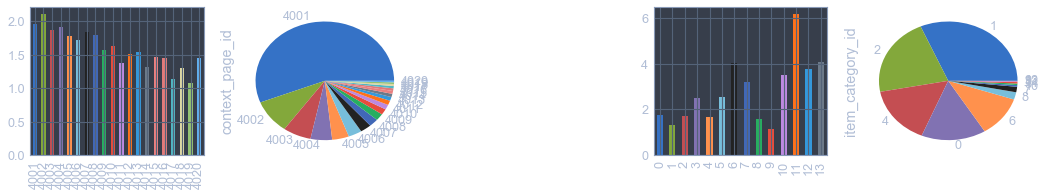

In [8]:
# context info
f = plt.figure(figsize=(18,6))

# plot user age trade rates
a = train_df['context_page_id'].value_counts()
y = train_df.loc[train_df['is_trade'] == 1]['context_page_id'].value_counts()
(y / a * 100).plot.bar(ax=f.add_subplot(251))
a.plot.pie(ax=f.add_subplot(252))

# plot item category trade rates
a = train_df['item_category_id'].value_counts()
y = train_df.loc[train_df['is_trade'] == 1]['item_category_id'].value_counts()
(y / a * 100).plot.bar(ax=f.add_subplot(254))
a.plot.pie(ax=f.add_subplot(255))

> 构建目录预测相关性数据，大约95%的数据和上下文预测的根目录匹配，所以我们从二级目录开始考虑

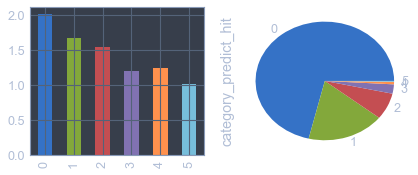

In [9]:
train_df = pd.read_csv(cf.round1_train_file_path, sep = ' ')
# context info
f = plt.figure(figsize=(18,6))

def predict_category_hit(row):
    ret = 0
    pre_list = row['predict_category_property'].split(';')
    category_list = row['item_category_list'].split(';')
    # start with second level category
    for i in category_list[1:]:
        for k in range(len(pre_list)):
            if i in pre_list[k]:
                # combime small datas.
                if ret == 0 or k < ret:
                    ret = 5 if k > 5 else k
    return ret

# context category predict info
if 'category_predict_hit' not in train_df:
    cp = train_df[['item_category_list', 'predict_category_property']]
    frame = cp.apply(predict_category_hit, axis=1)
    frame.name = 'category_predict_hit'
    train_df = train_df.join(frame)
    
# plot category predict trade rates
a = train_df['category_predict_hit'].value_counts()
y = train_df.loc[train_df['is_trade'] == 1]['category_predict_hit'].value_counts()
(y / a * 100).plot.bar(ax=f.add_subplot(251))
a.plot.pie(ax=f.add_subplot(252))

In [10]:
# context info
# 构建属性命中相关性数据
train_df = pd.read_csv(cf.round1_train_file_path, sep = ' ')

property_map = {}
property_list = train_df['item_property_list']
for props in property_list:
    for prop in props.split(';'):
        if prop in property_map:
            property_map[prop] += 1
        else:
            property_map[prop] = 1
prop_df = pd.DataFrame(property_map.items(), columns=['property_id', 'doc_freq'])

predict_map = {}
predict_list = train_df['predict_category_property']
for cate_props in predict_list:
    for cate_prop in cate_props.split(';'):
        cp_pair = cate_prop.split(':')
        if len(cp_pair) < 2 or cp_pair[1] == -1:
            continue
        props = cp_pair[1]
        for prop in props.split(','):
            if prop in predict_map:
                predict_map[prop] += 1
            else:
                predict_map[prop] = 1
pred_df = pd.DataFrame(predict_map.items(), columns=['property_id', 'pre_freq'])
prop_df = prop_df.merge(pred_df)

In [11]:
predict_map

{'4615922107210037634': 2,
 '8311658760088702115': 190,
 '6908827433922489614': 2,
 '4586716338952763313': 1916,
 '2376748065898842308': 8,
 '4150903726712768421': 6,
 '1789288754799680056': 30,
 '600832441806860945': 132,
 '1279011791132904433': 1,
 '1302524211476398932': 36,
 '5238292632612719358': 623,
 '4913099718482300153': 1990,
 '1914459684371024600': 55,
 '8274692449501786343': 129,
 '5294979155797339020': 8604,
 '80340571259176516': 1,
 '7702116691190255405': 369,
 '3076147129905082622': 13,
 '7885993884152480461': 69,
 '4399657928407404983': 4,
 '5250928339820605915': 5246,
 '4067341101015777832': 86,
 '7583628788399193310': 2,
 '6064195102325444681': 4,
 '117253231633290777': 351,
 '1690626079077103915': 10,
 '5818524590372601736': 74,
 '6065994034091750740': 2,
 '4767444444665890102': 3,
 '358174970251366030': 1,
 '4384295801392447606': 58,
 '8897102703871707817': 1,
 '8980775093245230022': 70,
 '5903984687624666123': 202,
 '5320468090843686429': 24,
 '97343083714326884': 5

1    202913
0    132983
2     82655
3     59587
Name: property_predict_hit, dtype: int64
1    3737
0    2762
2    1563
3     959
Name: property_predict_hit, dtype: int64


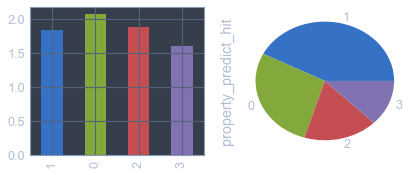

In [12]:
train_df = pd.read_csv(cf.round1_train_file_path, sep = ' ')
# context info
f = plt.figure(figsize=(18,6))

def predict_property_hit(row):
    ret = 0
    pre_list = row['predict_category_property'].split(';')
    property_list = row['item_property_list'].split(';')
    for i in range(len(property_list)):
        for k in pre_list:
            if property_list[i] in k:
                ret += float(1) / property_map[property_list[i]]
#     return ret
    if ret == 0:
        return 0
    elif ret <= 0.00001:
        return 1
    elif ret <= 0.00003:
        return 2
    else:
        return 3

# context property predict info
if 'property_predict_hit' not in train_df:
    cp = train_df[['item_category_list', 'item_property_list', 'predict_category_property']]
    frame = cp.apply(predict_property_hit, axis=1)
    frame.name = 'property_predict_hit'
    train_df = train_df.join(frame)
    
# plot property predict trade rates
a = train_df['property_predict_hit'].value_counts()
y = train_df.loc[train_df['is_trade'] == 1]['property_predict_hit'].value_counts()
(y / a * 100).plot.bar(ax=f.add_subplot(254))
a.plot.pie(ax=f.add_subplot(255))
print a
print y

> 数据只有7天，17号数据只有16点之前的，24号数据只有16点之后的，暂不考虑引入星期等日期特征

In [13]:
# datetime info
f = plt.figure(figsize=(18,6))
# by hours
train_df.loc[:,'context_hour'] = train_df.loc[:,'context_datetime'].map(lambda x:x.hour)
test_df.loc[:,'context_hour'] = test_df.loc[:,'context_datetime'].map(lambda x:x.hour)

# plot day
a = train_df['context_day'].value_counts()
y = train_df.loc[train_df['is_trade'] == 1]['context_day'].value_counts()
(y / a * 100).plot.bar(ax=f.add_subplot(251))
a.plot.pie(ax=f.add_subplot(252))
print a

# plot hour
a = train_df['context_hour'].value_counts()
y = train_df.loc[train_df['is_trade'] == 1]['context_hour'].value_counts()
(y / a * 100).plot.bar(ax=f.add_subplot(254))
a.plot.pie(ax=f.add_subplot(255))

# plot hour
trainW1_df = train_df.loc[(train_df['context_datetime'] >= '2017-09-18') & (train_df['context_datetime'] < '2017-09-23')]
a = trainW1_df['context_hour'].value_counts()
y = trainW1_df.loc[trainW1_df['is_trade'] == 1]['context_hour'].value_counts()
(y / a * 100).plot.bar(ax=f.add_subplot(256))
a.plot.pie(ax=f.add_subplot(257))

# plot hour
trainW2_df = train_df.loc[train_df['context_datetime'] >= '2017-09-23']
a = trainW2_df['context_hour'].value_counts()
y = trainW2_df.loc[trainW2_df['is_trade'] == 1]['context_hour'].value_counts()
(y / a * 100).plot.bar(ax=f.add_subplot(259))
a.plot.pie(ax=f.add_subplot(2,5,10))

KeyError: u'the label [context_datetime] is not in the [columns]'